*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2022-08-14 13:29:40.278180: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-14 13:29:40.288893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-14 13:29:40.288958: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-08-14 13:29:43--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.19’

insurance.csv.19    100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2022-08-14 13:29:43 (55.1 MB/s) - ‘insurance.csv.19’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
len(dataset)

1338

# Clean and Correlate

In [4]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [5]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


Make sure to convert categorical data to numbers. 

One thing to consider is the region variable. Let's look at the unique values there.

In [6]:
dataset.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Going to manually map the regions rather than using OneHotEncoder.

southwest: 1\
southeast: 2\
northwest: 3\
northeast: 4

In [7]:
smoker_bin = dataset.smoker.map(dict(yes=1, no=0))

sex_bin = dataset.sex.map(dict(female=0, male=1))

dataset.smoker = smoker_bin
dataset.sex = sex_bin


region_enc = dataset.region.map(dict(southwest=1, southeast=2, northwest=3, northeast=4))
dataset.region = region_enc

In [8]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,1,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,3,21984.47
4,32,1,28.9,0,0,3,3866.86


The expenses variable seems to have some significant distribution. Let's look at all of the non-binary variable distributions two ways.

These variables are: age, bmi, children, region, expenses

/home/ksmith/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ksmith/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ksmith/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

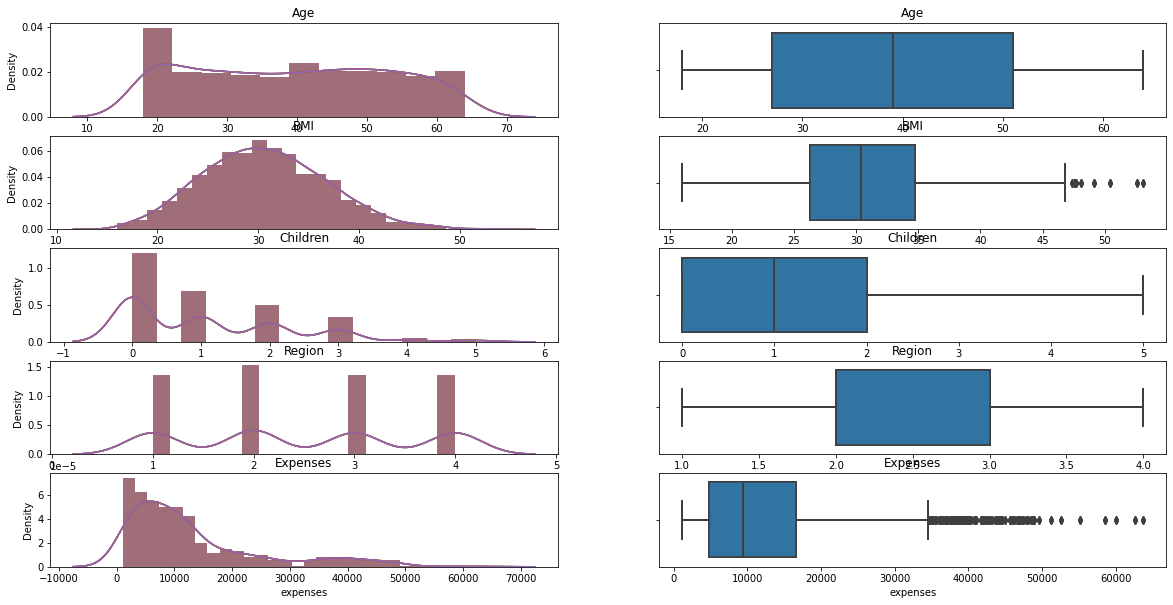

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

dist_dataset = dataset.loc[:,['age', 'bmi', 'children', 'region', 'expenses']]


def dist_plotter(df):
    # create the figure
    fig, ax = plt.subplots(5, 2, figsize=(20, 10))
    
    # create the plots:
    for n in range(len(df.columns)):
        # column 0 will be distplots
        sns.distplot(df.age, ax=ax[0, 0]).set(title='Age')
        sns.distplot(df.bmi, ax=ax[1, 0]).set(title='BMI')
        sns.distplot(df.children, ax=ax[2, 0]).set(title='Children')
        sns.distplot(df.region, ax=ax[3, 0]).set(title='Region')
        sns.distplot(df.expenses, ax=ax[4, 0]).set(title='Expenses')

        # column 1 will be boxplots
        sns.boxplot(x=df.age, ax=ax[0, 1]).set(title='Age')
        sns.boxplot(x=df.bmi, ax=ax[1, 1]).set(title='BMI')
        sns.boxplot(x=df.children, ax=ax[2, 1]).set(title='Children')
        sns.boxplot(x=df.region, ax=ax[3, 1]).set(title='Region')
        sns.boxplot(x=df.expenses, ax=ax[4, 1]).set(title='Expenses')

    plt.show()

dist_plotter(dist_dataset)

BMI and Expenses clearly have some extreme outliers.

Let's use IQR to take out the outliers.

In [10]:
def remove_outliers(df, columns):
    for col in columns:
        q25, q75 = df[col].quantile(.25), df[col].quantile(.75)

        IQR = q75 - q25

        lower_range = q25 - 1.5 * IQR
        upper_range = q75 + 1.5 * IQR

        outlier_free_list = [x for x in df[col] if (
            (x > lower_range) & (x < upper_range)
        )]

        filtered_data = df.loc[df[col].isin(outlier_free_list)]

    return filtered_data

dataset = remove_outliers(dataset, ['bmi', 'expenses'])

dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,1,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,3,21984.47
4,32,1,28.9,0,0,3,3866.86


In [11]:
len(dataset)

1199

<AxesSubplot:>

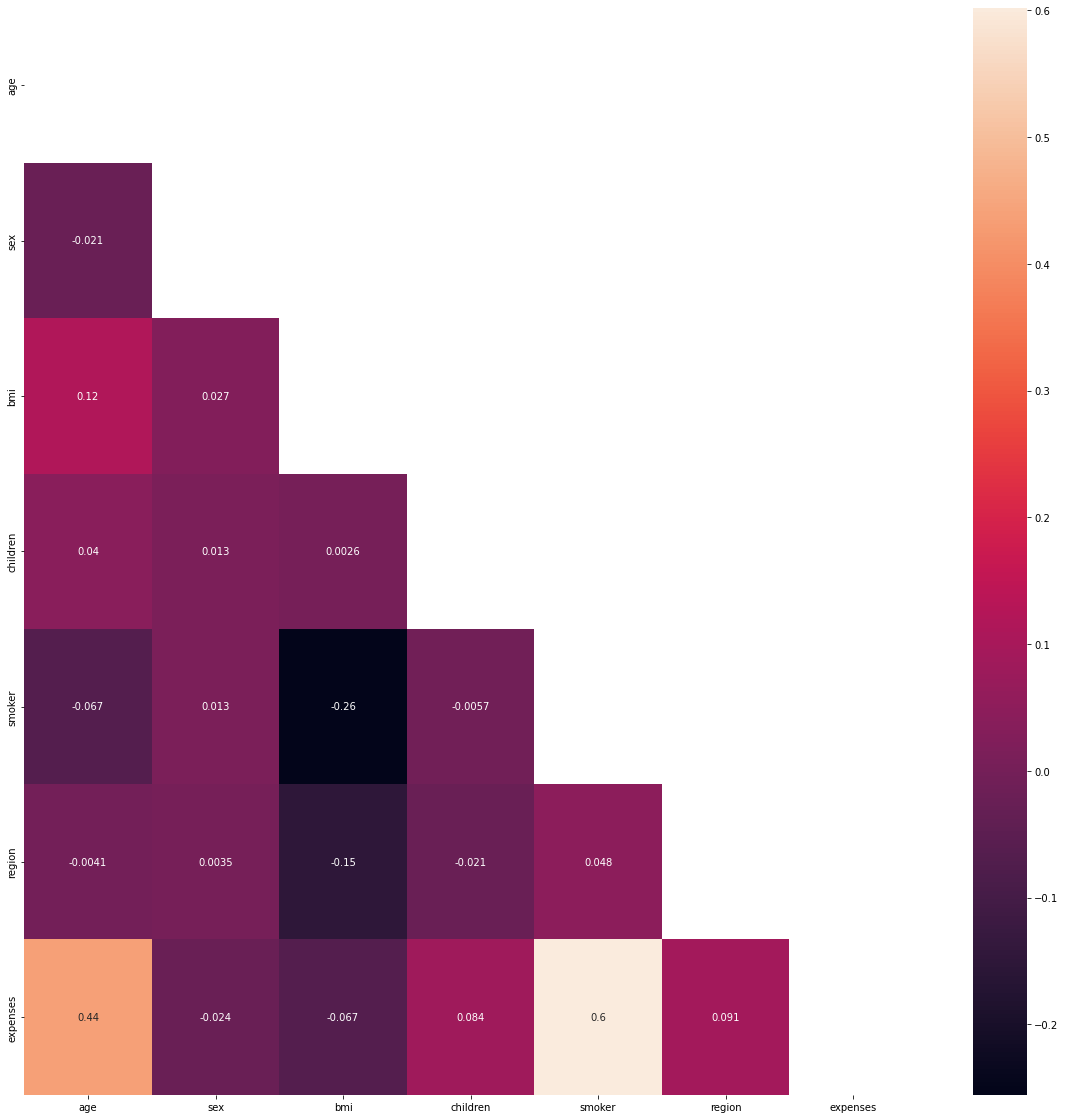

In [12]:
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(corr, mask=mask, annot=True)


Smoker clearly has the highest impact on the expenses variable. Age seems to be the next most impactful. Otherwise, the other variables are negligible.

# Using Tensorflow

Example: https://www.tensorflow.org/tutorials/keras/regression

In [13]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=.2)

train_features = train_dataset[['age', 'smoker', 'expenses']].copy()
test_features = test_dataset[['age', 'smoker', 'expenses']].copy()

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')


### Normailizing

Normalizing data is important, especially when multiple features are all on different scales.

In [14]:
normalizer = layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(np.array(train_features))

2022-08-14 13:29:50.455710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-14 13:29:50.455762: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-14 13:29:50.455793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gear): /proc/driver/nvidia/version does not exist
2022-08-14 13:29:50.456202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
print(normalizer.mean.numpy())


[[3.9008339e+01 1.2200207e-01 1.0028878e+04]]


In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[  48.      0.   9447.38]]

Normalized: [[ 0.64 -0.37 -0.08]]


In [18]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])


In [19]:
model.predict(train_features[:10])


1/1 [==============================] - 0s 154ms/step


array([[ 0.02029267],
       [ 1.6099906 ],
       [ 2.0538979 ],
       [-0.08153821],
       [ 1.6661112 ],
       [-0.42095655],
       [ 0.6094377 ],
       [-0.29000044],
       [-4.296652  ],
       [ 0.00853041]], dtype=float32)

In [20]:
model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.5095253 ],
       [-0.7288728 ],
       [-0.94728875]], dtype=float32)>

In [21]:
# When evaluating the model, this will give loss, mae, and mse as the metrics when metrics_names() is called
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1.5),
    loss=['mean_absolute_error'], 
    metrics=['mae', 'mse']
    )


In [22]:
test_results = {}

In [23]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=400,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


CPU times: user 44.8 s, sys: 6.48 s, total: 51.3 s
Wall time: 35.4 s


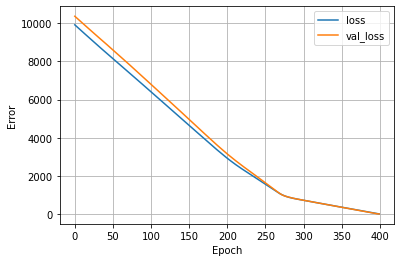

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)


In [25]:
# model.metrics_names

In [26]:
# loss, mae, mse = model.evaluate(test_features, test_labels, verbose=2)

In [28]:
test_dataset = test_features
test_labels = test_labels

8/8 - 0s - loss: 0.7718 - mae: 0.7718 - mse: 0.9007 - 51ms/epoch - 6ms/step
Testing set Mean Abs Error:  0.77 expenses
You passed the challenge. Great job!
8/8 [==============================] - 0s 2ms/step


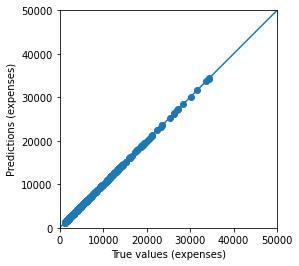

In [29]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
